In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random

np.random.seed(17)      # set the random number generator seed

# Parameters for the Vicsek model
N = 200  # number of birds
L = 500  # size of the domain

eta = 1  # noise
v = 10  # velocity of birds
dt = 0.5   # time step
R = 10     # radius of interaction
Nt = 500  # number of time steps
Rsq = R**2
r = 2 #minimum distance between birds
# Parameters for drones
Nd = 6 # number of drones
vd = 18  # constant speed of drones
Rd = 20  # range of influence of drones
v_max = 16

lambda_c = 1
lambda_a = 1
lambda_m = 1

# Initialize birds
def initialize_birds(N, L):
    x = np.random.rand(N) * L
    y = np.random.rand(N) * L
    theta = np.random.rand(N) * 2 * np.pi
    vx = v * np.cos(theta)
    vy = v * np.sin(theta)
    return x, y, vx, vy, theta

# Initialize drones
def initialize_drones(Nd, L):
    x = np.random.rand(Nd) * L
    y = np.random.rand(Nd) * L
    theta = np.random.rand(Nd) * 2 * np.pi
    vx = vd * np.cos(theta)
    vy = vd * np.sin(theta)
    return x, y, vx, vy

def get_local_birds(x, y, i, R):
    # Identify neighbors within the interaction radius
    dist_sq = (x - x[i])**2 + (y - y[i])**2
    within_radius = dist_sq < R**2
    local_birds = [j for j in range(len(x)) if within_radius[j] and i != j]
    return local_birds

def get_too_close_birds(x, y, i, r):
    # Identify birds within the minimum distance
    dist_sq = (x - x[i])**2 + (y - y[i])**2
    too_close_birds = [j for j in range(len(x)) if dist_sq[j] < r**2 and i != j]
    return too_close_birds


# Vicsek model update for birds
def update(x, y, vx, vy, theta, Rsq, eta, N, dt, r, drone_x, drone_y, Rd):
    for i in range(N):
        # Calculate distance to each bird
        dx = x - x[i]
        dy = y - y[i]
        dist_sq = dx**2 + dy**2

        # Identify neighbors within the interaction radius
        within_radius = dist_sq < Rsq

        # Avoidance rule to keep minimum distance
        avoid_collisions = np.zeros(2)
        for j in range(N):
            if i != j and dist_sq[j] < r**2:
                avoid_collisions += r / (np.sqrt(dist_sq[j]) + 1e-5) * np.array([x[i] - x[j], y[i] - y[j]])

        # Dispersal rule when a drone is in the radius
        dx_drone = x[i] - drone_x
        dy_drone = y[i] - drone_y
        dist_sq_drone = dx_drone**2 + dy_drone**2
        within_radius_drone = dist_sq_drone < Rd**2
        v_c = np.zeros(2)
        if np.any(within_radius_drone):
            # Move away from the drone's position
            #theta[i] = np.arctan2(dy_drone.mean(), dx_drone.mean()) + eta * (np.random.rand() - 0.5)
            theta[i] = np.arctan2(-vy[i], -vx[i])
        elif np.sum(within_radius) > 0:
            center_of_mass = np.array([np.sum(x[within_radius]) / np.sum(within_radius),
                                       np.sum(y[within_radius]) / np.sum(within_radius)])
            v_c = center_of_mass - np.array([x[i], y[i]])
        # Vicsek model update
        theta[i] = np.arctan2(vy[within_radius].mean(), vx[within_radius].mean()) + eta * (np.random.rand() - 0.5)

        # Update velocity
        vx[i] = v * np.cos(theta[i]) + v_c[0] + avoid_collisions[0]
        vy[i] = v * np.sin(theta[i]) + v_c[1] + avoid_collisions[1]

    # Update positions
    x += vx * dt
    y += vy * dt

    # Apply periodic boundary conditions
    x = x % L
    y = y % L

    return x, y, vx, vy

# Function to limit speed
def limit_speed(vx, vy, v_max):
    speed = np.linalg.norm([vx, vy])
    if speed > v_max:
        vx = (v_max / speed) * vx
        vy = (v_max / speed) * vy   
    return vx, vy

def update_velocities(x, y, vx_i, vy_i, i, x_drones, y_drones, R_drone):
    local_birds = get_local_birds(x, y, i, R)
    too_close_birds = get_too_close_birds(x, y, i, r)
    v_c = lambda_c * (
        (np.sum([x[j] for j in local_birds]) / len(local_birds) - x[i]) if len(local_birds) > 0 else 0,
        (np.sum([y[j] for j in local_birds]) / len(local_birds) - y[i]) if len(local_birds) > 0 else 0 )
    v_a = lambda_a * (
        (np.sum([x[i] - x[j] for j in too_close_birds]) if len(too_close_birds) > 0 else 0),
        (np.sum([y[i] - y[j] for j in too_close_birds]) if len(too_close_birds) > 0 else 0))
    v_m = lambda_m * (
        (np.sum([vx[j] for j in local_birds]) / len(local_birds) - vx_i) if len(local_birds) > 0 else 0,
        (np.sum([vy[j] for j in local_birds]) / len(local_birds) - vy_i) if len(local_birds) > 0 else 0)
    vx_i_new = vx_i + v_c[0] + v_a[0] + v_m[0] 
    vy_i_new = vy_i + v_c[1] + v_a[1] + v_m[1] 

    # Limit speed
    vx_i_new, vy_i_new = limit_speed(vx_i_new, vy_i_new, v_max)
    # Check if the bird is within the observation range of any drone
    for d in range(Nd):
        distance_to_drone = np.linalg.norm([x[i] - x_drones[d], y[i] - y_drones[d]])
        if distance_to_drone < R_drone:
            # Birds within R_drone experience a negative velocity
            vx_i_new, vy_i_new = -vx_i_new, -vy_i_new
            break
    return vx_i_new, vy_i_new


def update_drones(drone_x, drone_y, drone_vx, drone_vy, x, y, L, vd, dt, Rd, r):
    # Move drones towards the direction with the most birds in their radius
    for i in range(Nd):
        # Calculate distance to each bird
        dx_to_bird = x - drone_x[i]
        dy_to_bird = y - drone_y[i]
        dist_sq = dx_to_bird**2 + dy_to_bird**2

        # Identify birds within the drone's range
        within_radius = dist_sq < Rd**2
        N_birds_in_radius = np.sum(within_radius)

        # Find the centroid of birds within the drone's range
        if N_birds_in_radius > 0:
            centroid = np.array([np.sum(x[within_radius]) / N_birds_in_radius, np.sum(y[within_radius]) / N_birds_in_radius])
            # Calculate direction vector towards the centroid
            direction_to_centroid = centroid - np.array([drone_x[i], drone_y[i]])
            # Normalize the direction vector
            direction_to_centroid /= np.linalg.norm(direction_to_centroid)
            # Adjust drone's velocity towards the centroid
            drone_vx[i] = vd * direction_to_centroid[0]
            drone_vy[i] = vd * direction_to_centroid[1]
        else:
            # If no birds are in radius, move straight ahead
            random_direction = 2 * np.pi * np.random.rand()
            drone_vx[i] = vd * np.cos(random_direction)
            drone_vy[i] = vd * np.sin(random_direction)

        # Move drones straight ahead
        drone_x[i] += drone_vx[i] * dt
        drone_y[i] += drone_vy[i] * dt

        # Apply periodic boundary conditions
        drone_x[i] = drone_x[i] % L
        drone_y[i] = drone_y[i] % L

        # Avoid collisions between drones
        for j in range(Nd):
            if i != j:
                dx_to_drone = drone_x[j] - drone_x[i]
                dy_to_drone = drone_y[j] - drone_y[i]
                distance_between_drones = np.sqrt(dx_to_drone**2 + dy_to_drone**2)

                # Adjust velocities to avoid collisions
                if distance_between_drones < r:
                    # Calculate direction vector away from the other drone
                    direction_away_from_drone = np.array([dx_to_drone, dy_to_drone])
                    direction_away_from_drone /= np.linalg.norm(direction_away_from_drone)

                    # Adjust velocities to avoid collision
                    drone_vx[i] -= direction_away_from_drone[0]
                    drone_vy[i] -= direction_away_from_drone[1]

    return drone_x, drone_y, drone_vx, drone_vy

# Visualization function
def visualize(x, y, vx, vy, drone_x, drone_y):
    plt.figure(figsize=(8, 8))

    # Plot birds as small diamonds
    plt.scatter(x, y, c='black', marker='D', s=10, label='Birds')

    # Plot drones as red diamonds
    plt.scatter(drone_x, drone_y, c='red', marker='D', s=15, label='Drones')

    plt.xlim(0, L)
    plt.ylim(0, L)
    plt.title("Birds and Drones Interaction")
    plt.show()

In [25]:
# Parameters for the Vicsek model
N = 200  # number of birds
L = 500  # size of the domain

eta = 1  # noise
v = 10  # velocity of birds
dt = 1   # time step
R = 10     # radius of interaction
Nt = 120  # number of time steps
Rsq = R**2
r = 2 #minimum distance between birds

# Parameters for drones
Nd = 6 # number of drones
vd = 18  # constant speed of drones
Rd = 20  # range of influence of drones
v_max = 16

# Define a range of drone numbers
drone_numbers = range(1, 10)

# Initialize a list to store the flock sizes for each number of drones
all_flock_sizes = []

for Nd in drone_numbers:
    # Initialize birds and drones
    x, y, vx, vy, theta = initialize_birds(N, L)
    drone_x, drone_y, drone_vx, drone_vy = initialize_drones(Nd, L)

    # Initialize a list to store the average flock sizes for this number of drones
    avg_flock_sizes = []

    for _ in range(Nt):
        drone_x, drone_y, drone_vx, drone_vy = update_drones(drone_x, drone_y, drone_vx, drone_vy, x, y, L, vd, dt, Rd, r)
        
        # Calculate the sizes of all flocks
        flock_sizes = [len(get_local_birds(x, y, i, R)) for i in range(N)]
        
        # Calculate the average flock size
        avg_flock_size = sum(flock_sizes) / N
        avg_flock_sizes.append(avg_flock_size)

        for i in range(N):
            vx[i], vy[i] = update_velocities(x, y, vx[i], vy[i], i, drone_x, drone_y, Rd)

        x, y, vx, vy = update(x, y, vx, vy, theta, Rsq, eta, N, dt, r, drone_x, drone_y, Rd)

    # Store the average flock sizes for this number of drones
    all_flock_sizes.append(avg_flock_sizes)



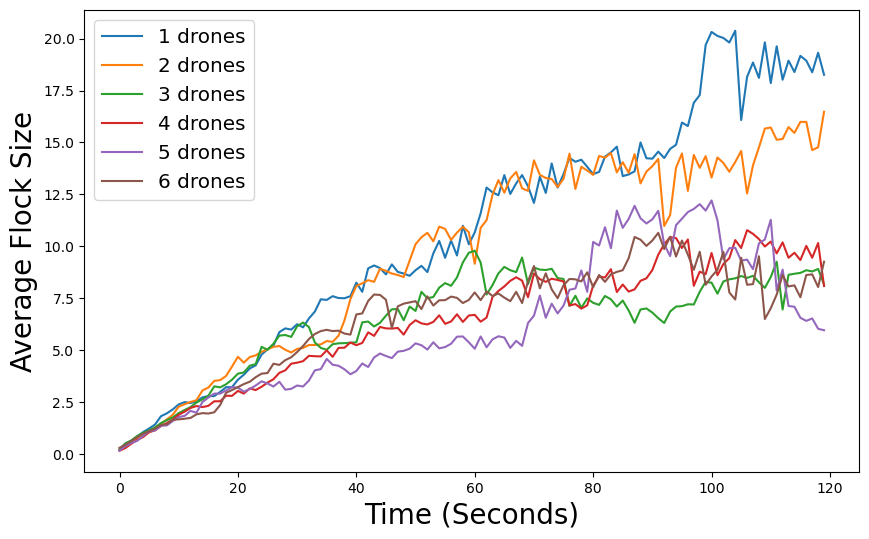

In [43]:
# Plot the results
plt.figure(figsize=(10, 6))
for Nd, avg_flock_sizes in zip(drone_numbers, all_flock_sizes):
    plt.plot(range(Nt), avg_flock_sizes, label=f'{Nd} drones')
plt.xlabel('Time (Seconds)',size=20)
plt.ylabel('Average Flock Size',size=20)
plt.title('')
plt.legend(fontsize='x-large')

# Save the figure as a PDF file
plt.savefig('dispering_changing_drone_number.pdf', format='pdf')

plt.show()

In [16]:
# import numpy as np

# def moving_average(data, window_size):
#     return np.convolve(data, np.ones(window_size), 'valid') / window_size

# window_size = 20  # Choose a suitable window size

# # Plot the results
# plt.figure(figsize=(10, 6))
# for Nd, avg_flock_sizes in zip(drone_numbers, all_flock_sizes):
#     smoothed = moving_average(avg_flock_sizes, window_size)
#     plt.plot(range(len(smoothed)), smoothed, label=f'{Nd} drones')
# plt.xlabel('Time step')
# plt.ylabel('Average flock size')
# plt.title('Average flock size over time for different numbers of drones')
# plt.legend()

# # Save the figure as a PDF file
# plt.savefig('dispering_changing_drone_number.pdf', format='pdf')

# plt.show()




In [30]:
# Parameters for the Vicsek model
N = 200  # number of birds
L = 500  # size of the domain

eta = 1  # noise
v = 10  # velocity of birds
dt = 1   # time step
R = 10     # radius of interaction
Nt = 120  # number of time steps
Rsq = R**2
r = 2 #minimum distance between birds

# Parameters for drones
Nd = 5 # number of drones
vd = 18  # constant speed of drones
Rd = 20  # range of influence of drones
v_max = 16

np.random.seed(17)      # set the random number generator seed


# Define a range of drone speeds
drone_speeds = [5, 10, 12.5, 15, 17.5, 20, 25, 30]  # Adjust as needed

# Initialize a list to store the average flock sizes for each drone speed
all_flock_sizes = []


for vd in drone_speeds:
    # Initialize birds and drones
    x, y, vx, vy, theta = initialize_birds(N, L)
    drone_x, drone_y, drone_vx, drone_vy = initialize_drones(Nd, L)

    # Initialize a list to store the average flock sizes for this drone speed
    avg_flock_sizes = []

    for _ in range(Nt):
        drone_x, drone_y, drone_vx, drone_vy = update_drones(drone_x, drone_y, drone_vx, drone_vy, x, y, L, vd, dt, Rd, r)
        
        # Calculate the sizes of all flocks
        flock_sizes = [len(get_local_birds(x, y, i, R)) for i in range(N)]
        
        # Calculate the average flock size
        avg_flock_size = sum(flock_sizes) / N
        avg_flock_sizes.append(avg_flock_size)

        for i in range(N):
            vx[i], vy[i] = update_velocities(x, y, vx[i], vy[i], i, drone_x, drone_y, Rd)

        x, y, vx, vy = update(x, y, vx, vy, theta, Rsq, eta, N, dt, r, drone_x, drone_y, Rd)

    # Store the average flock sizes for this drone speed
    all_flock_sizes.append(avg_flock_sizes)


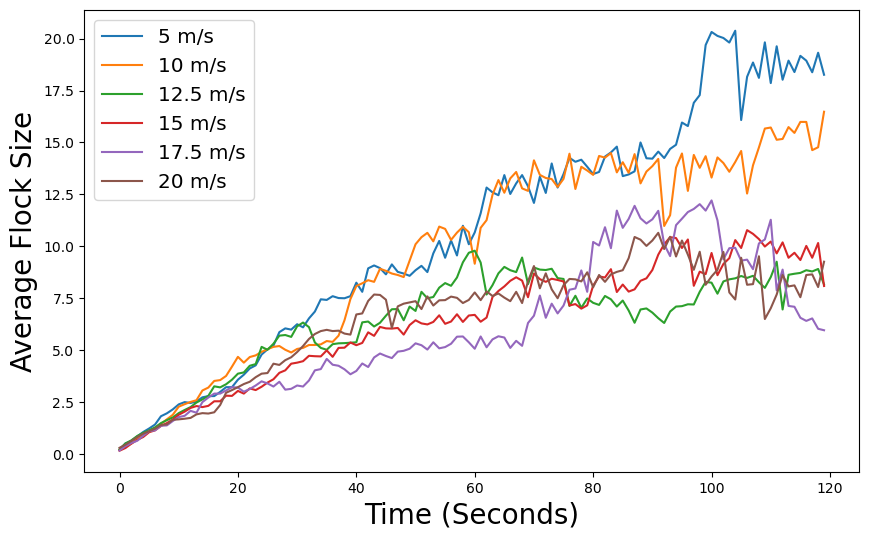

In [42]:
# Plot the results
plt.figure(figsize=(10, 6))
for vd, avg_flock_sizes in zip(drone_speeds, all_flock_sizes):
    plt.plot(range(Nt), avg_flock_sizes, label=f'{vd} m/s')
plt.xlabel('Time (Seconds)',size=20)
plt.ylabel('Average Flock Size',size=20)
plt.title('')
plt.legend(fontsize='x-large')

# Save the figure as a PDF file
plt.savefig('dispering_changing_drone_speed.pdf', format='pdf')

plt.show()

In [29]:
# import numpy as np

# def moving_average(data, window_size):
#     return np.convolve(data, np.ones(window_size), 'valid') / window_size

# window_size = 20  # Choose a suitable window size

# # Plot the results
# plt.figure(figsize=(10, 6))
# for vd, avg_flock_sizes in zip(drone_speeds, all_flock_sizes):
#     smoothed = moving_average(avg_flock_sizes, window_size)
#     plt.plot(range(len(smoothed)), smoothed, label=f'{vd} *speed unit*')
# plt.xlabel('Time step')
# plt.ylabel('Average flock size')
# plt.title('Average flock size over time for different drone speeds')
# plt.legend()

# # # Save the figure as a PDF file
# # plt.savefig('dispering_changing_drone_speed.pdf', format='pdf')

# plt.show()

In [37]:
# Parameters for the Vicsek model
N = 200  # number of birds
L = 500  # size of the domain

eta = 1  # noise
v = 10  # velocity of birds
dt = 1   # time step
R = 10     # radius of interaction
Nt = 120  # number of time steps
Rsq = R**2
r = 2 #minimum distance between birds

# Parameters for drones
Nd = 5 # number of drones
vd = 18  # constant speed of drones
Rd = 20  # range of influence of drones
v_max = 16

np.random.seed(17)      # set the random number generator seed

# Define a range of drone influence radii
drone_radii = [5, 10, 15, 20, 25, 30]  # Adjust as needed

# Initialize a list to store the average flock sizes for each drone influence radius
all_flock_sizes = []



for Rd in drone_radii:
    # Initialize birds and drones
    x, y, vx, vy, theta = initialize_birds(N, L)
    drone_x, drone_y, drone_vx, drone_vy = initialize_drones(Nd, L)

    # Initialize a list to store the average flock sizes for this drone influence radius
    avg_flock_sizes = []

    for _ in range(Nt):
        drone_x, drone_y, drone_vx, drone_vy = update_drones(drone_x, drone_y, drone_vx, drone_vy, x, y, L, vd, dt, Rd, r)
        
        # Calculate the sizes of all flocks
        flock_sizes = [len(get_local_birds(x, y, i, R)) for i in range(N)]
        
        # Calculate the average flock size
        avg_flock_size = sum(flock_sizes) / N
        avg_flock_sizes.append(avg_flock_size)

        for i in range(N):
            vx[i], vy[i] = update_velocities(x, y, vx[i], vy[i], i, drone_x, drone_y, Rd)

        x, y, vx, vy = update(x, y, vx, vy, theta, Rsq, eta, N, dt, r, drone_x, drone_y, Rd)

    # Store the average flock sizes for this drone influence radius
    all_flock_sizes.append(avg_flock_sizes)


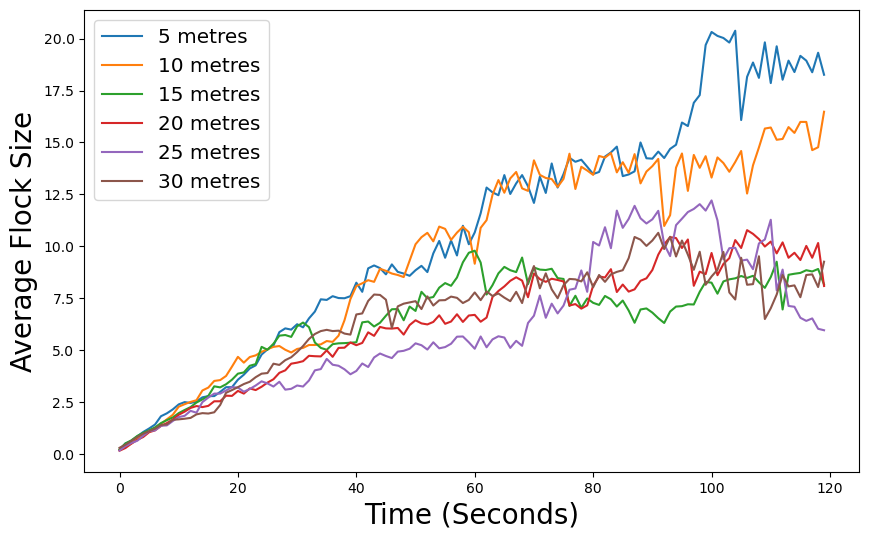

In [41]:
# Plot the results
plt.figure(figsize=(10, 6))
for Rd, avg_flock_sizes in zip(drone_radii, all_flock_sizes):
    plt.plot(range(Nt), avg_flock_sizes, label=f'{Rd} metres')
plt.xlabel('Time (Seconds)',size=20)
plt.ylabel('Average Flock Size',size=20)
plt.title('')
plt.legend(fontsize='x-large')

# Save the figure as a PDF file
plt.savefig('dispering_changing_drone_radii.pdf', format='pdf')

plt.show()

In [34]:
# import numpy as np

# def moving_average(data, window_size):
#     return np.convolve(data, np.ones(window_size), 'valid') / window_size

# window_size = 20  # Choose a suitable window size

# # Plot the results
# plt.figure(figsize=(10, 6))
# for Rd, avg_flock_sizes in zip(drone_radii, all_flock_sizes):
#     smoothed = moving_average(avg_flock_sizes, window_size)
#     plt.plot(range(len(smoothed)), smoothed, label=f'{Rd} *distance unit*')
# plt.xlabel('Time step')
# plt.ylabel('Average flock size')
# plt.title('Average flock size over time for different drone influence radii')
# plt.legend()

# # Save the figure as a PDF file
# plt.savefig('dispering_changing_drone_radii.pdf', format='pdf')

# plt.show()

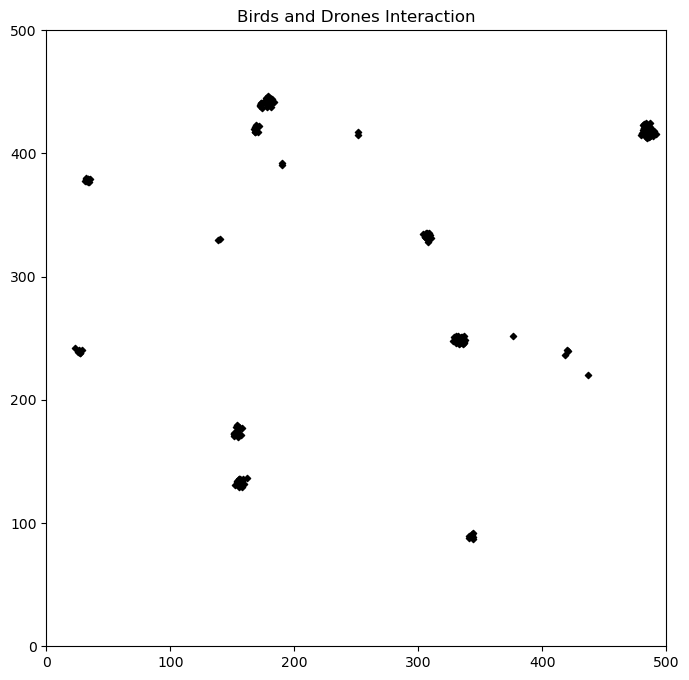

In [8]:
# Simulation
Nd = 0  # number of drones
vd = 0  # constant speed of drones
Rd = 0  # range of influence of drones

x, y, vx, vy, theta = initialize_birds(N, L)
drone_x, drone_y, drone_vx, drone_vy = initialize_drones(Nd, L)

flock_sizes = []  # List to store flock sizes at each time step

for _ in range(Nt):
    drone_x, drone_y, drone_vx, drone_vy = update_drones(drone_x, drone_y, drone_vx, drone_vy, x, y, L, vd, dt, Rd, r)
    flock_size = len(get_local_birds(x, y, 0, R))
    flock_sizes.append(flock_size)
    
    for i in range(N):
        vx[i], vy[i] = update_velocities(x, y, vx[i], vy[i], i, drone_x, drone_y, Rd)
    
    x, y, vx, vy = update(x, y, vx, vy, theta, Rsq, eta, N, dt, r, drone_x, drone_y, Rd)
    visualize(x, y, vx, vy, drone_x, drone_y)
    clear_output(wait=True)

In [44]:
# Parameters for the Vicsek model
N = 200  # number of birds
L = 500  # size of the domain

eta = 1  # noise
v = 10  # velocity of birds
dt = 1   # time step
R = 10     # radius of interaction
Nt = 120  # number of time steps
Rsq = R**2
r = 2 #minimum distance between birds

# Simulation
Nd = 0  # number of drones
vd = 0  # constant speed of drones
Rd = 0  # range of influence of drones

# Define a range of drone numbers
simulations = range(1, 11)

# Initialize a list to store the flock sizes for each number of drones
all_flock_sizes = []

for t in simulations:
    # Initialize birds and drones
    x, y, vx, vy, theta = initialize_birds(N, L)
    drone_x, drone_y, drone_vx, drone_vy = initialize_drones(Nd, L)

    # Initialize a list to store the average flock sizes for this number of drones
    avg_flock_sizes = []

    for _ in range(Nt):
        drone_x, drone_y, drone_vx, drone_vy = update_drones(drone_x, drone_y, drone_vx, drone_vy, x, y, L, vd, dt, Rd, r)
        
        # Calculate the sizes of all flocks
        flock_sizes = [len(get_local_birds(x, y, i, R)) for i in range(N)]
        
        # Calculate the average flock size
        avg_flock_size = sum(flock_sizes) / N
        avg_flock_sizes.append(avg_flock_size)

        for i in range(N):
            vx[i], vy[i] = update_velocities(x, y, vx[i], vy[i], i, drone_x, drone_y, Rd)

        x, y, vx, vy = update(x, y, vx, vy, theta, Rsq, eta, N, dt, r, drone_x, drone_y, Rd)

    # Store the average flock sizes for this number of drones
    all_flock_sizes.append(avg_flock_sizes)



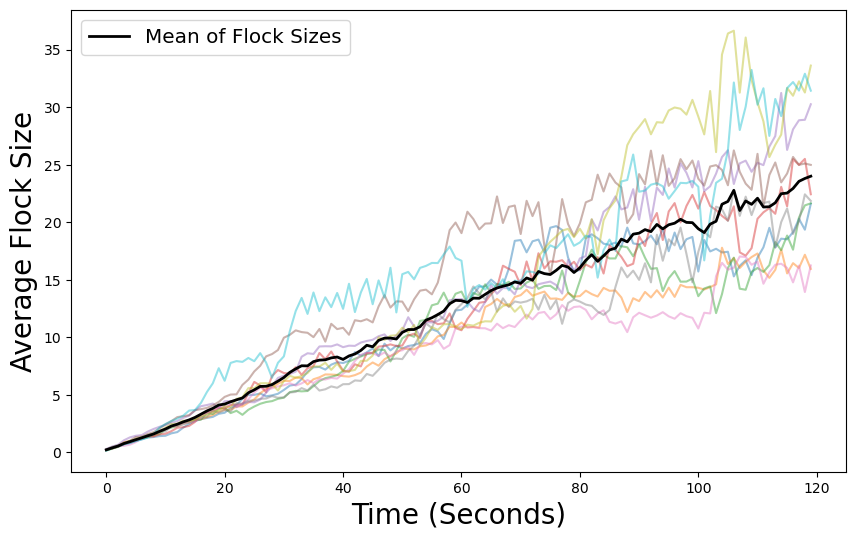

In [46]:

# Plot the results
plt.figure(figsize=(10, 6))
for t, avg_flock_sizes in zip(simulations, all_flock_sizes):
    plt.plot(range(Nt), avg_flock_sizes, alpha=0.45)  # Make these lines semi-transparent

# Calculate the mean of all_flock_sizes and plot it
mean_flock_sizes = np.mean(all_flock_sizes, axis=0)
plt.plot(range(Nt), mean_flock_sizes, color='black', linewidth=2, label='Mean of Flock Sizes')  # This line is fully opaque

plt.xlabel('Time (Seconds)',size=20)
plt.ylabel('Average Flock Size',size=20)
plt.title('')
plt.legend(fontsize='x-large')

# Save the figure as a PDF file
plt.savefig('zero_drones_10x.pdf', format='pdf')

plt.show()